# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = None
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)
The train shape is: (130, 27)
The test shape is: (33, 27)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

Age0-4(%)  Age5-14(%)  Age15-29(%)  Age>30(%)  \
41001 201546   0.706485    0.317881    -0.118812  -0.320472   
      201547   0.706485    0.317881    -0.118812  -0.320472   
      201548   0.706485    0.317881    -0.118812  -0.320472   
      201549   0.706485    0.317881    -0.118812  -0.320472   
      201550   0.706485    0.317881    -0.118812  -0.320472   

              AfrocolombianPopulation(%)  IndianPopulation(%)  \
41001 201546                   -0.974267            -0.181818   
      201547                   -0.974267            -0.181818   
      201548                   -0.974267            -0.181818   
      201549                   -0.974267            -0.181818   
      201550                   -0.974267            -0.181818   

              PeoplewithDisabilities(%)  Peoplewhocannotreadorwrite(%)  \
41001 201546                   0.492837                      -0.138643   
      201547                   0.492837                      -0.138643   
      201548                   0.492837                      -0.138643   
      201549                   0.492837                      -0.138643   
      201550                   0.492837                      -0.138643   

              Secondary/HigherEducation(%)  Employedpopulation(%)  ...  \
41001 201546                      -0.23619              -0.455798  ...   
      201547                      -0.23619              -0.455798  ...   
      201548                      -0.23619              -0.455798  ...   
      201549                      -0.23619              -0.455798  ...   
      201550                      -0.23619              -0.455798  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                    -0.38184                     0.90498   
      201547                    -0.38184                     0.90498   
      201548                    -0.38184                     0.90498   
      201549                    -0.38184                     0.90498   
      201550                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -0.917415                   -0.851179   
      201547                   -0.917415                   -0.851179   
      201548                   -0.917415                   -0.851179   
      201549                   -0.917415                   -0.851179   
      201550                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                     -0.7492                   -0.981855   
      201547                     -0.7492                   -0.981855   
      201548                     -0.7492                   -0.981855   
      201549                     -0.7492                   -0.981855   
      201550                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.990366               -0.9891   -0.924272   
      201547                -0.990366               -0.9891   -0.924272   
      201548                -0.990366               -0.9891   -0.924272   
      201549                -0.990366               -0.9891   -0.924272   
      201550                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201546 -0.861740  
      201547 -0.854589  
      201548 -0.856973  
      201549 -0.856973  
      201550 -0.823600  

[5 rows x 27 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

Age0-4(%)  Age5-14(%)  Age15-29(%)  Age>30(%)  \
41001 201820   0.706485    0.317881    -0.118812  -0.320472   
      201821   0.706485    0.317881    -0.118812  -0.320472   
      201822   0.706485    0.317881    -0.118812  -0.320472   
      201823   0.706485    0.317881    -0.118812  -0.320472   
      201824   0.706485    0.317881    -0.118812  -0.320472   

              AfrocolombianPopulation(%)  IndianPopulation(%)  \
41001 201820                   -0.974267            -0.181818   
      201821                   -0.974267            -0.181818   
      201822                   -0.974267            -0.181818   
      201823                   -0.974267            -0.181818   
      201824                   -0.974267            -0.181818   

              PeoplewithDisabilities(%)  Peoplewhocannotreadorwrite(%)  \
41001 201820                   0.492837                      -0.138643   
      201821                   0.492837                      -0.138643   
      201822                   0.492837                      -0.138643   
      201823                   0.492837                      -0.138643   
      201824                   0.492837                      -0.138643   

              Secondary/HigherEducation(%)  Employedpopulation(%)  ...  \
41001 201820                      -0.23619              -0.455798  ...   
      201821                      -0.23619              -0.455798  ...   
      201822                      -0.23619              -0.455798  ...   
      201823                      -0.23619              -0.455798  ...   
      201824                      -0.23619              -0.455798  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                    -0.38184                     0.90498   
      201821                    -0.38184                     0.90498   
      201822                    -0.38184                     0.90498   
      201823                    -0.38184                     0.90498   
      201824                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -0.917415                   -0.851179   
      201821                   -0.917415                   -0.851179   
      201822                   -0.917415                   -0.851179   
      201823                   -0.917415                   -0.851179   
      201824                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                     -0.7492                   -0.981855   
      201821                     -0.7492                   -0.981855   
      201822                     -0.7492                   -0.981855   
      201823                     -0.7492                   -0.981855   
      201824                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.990366               -0.9891   -0.924272   
      201821                -0.990366               -0.9891   -0.924272   
      201822                -0.990366               -0.9891   -0.924272   
      201823                -0.990366               -0.9891   -0.924272   
      201824                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201820 -0.949940  
      201821 -0.961859  
      201822 -0.940405  
      201823 -0.961859  
      201824 -0.954708  

[5 rows x 27 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 79)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 79)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 78)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 78)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 78)
The test shape is (310, 78)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 26)
The test shape is (310, 3, 26)


# 2. Model

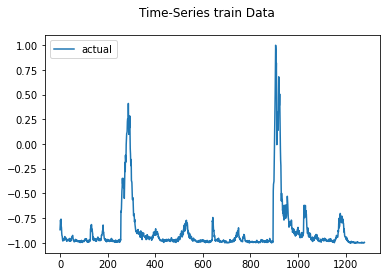

2023-03-08 15:26:02.447214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 15:26:02.447268: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 15:26:02.447289: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-08 15:26:02.447502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 15:26:03.837947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 38.132
Test RMSE: 45.264
Test sMAPE: 130.559
Test R Squared: -1.065
{'mae': 38.1323883810351, 'rmse': 45.26433181028294, 'smape': 130.5594183478378, 'r2': -1.0651288883800483}


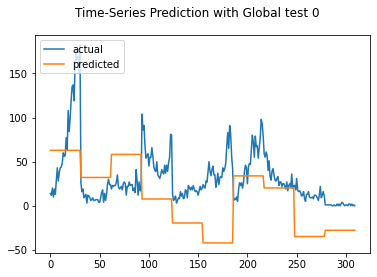

Test MAE: 41.361
Test RMSE: 48.753
Test sMAPE: 96.359
Test R Squared: -1.396
{'mae': 41.36114206621724, 'rmse': 48.75326539134278, 'smape': 96.35850865628503, 'r2': -1.3957547217923727}


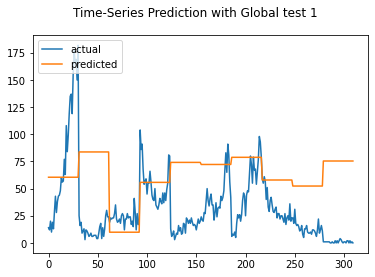

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 42.815
Test RMSE: 57.209
Test sMAPE: 101.821
Test R Squared: -2.299
{'mae': 42.81476443813693, 'rmse': 57.20895283583109, 'smape': 101.82067617192008, 'r2': -2.2988527564348744}


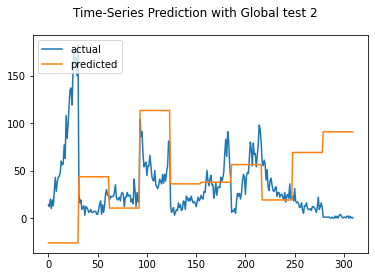

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 42.088
Test RMSE: 54.134
Test sMAPE: 114.203
Test R Squared: -1.954
{'mae': 42.088094905884034, 'rmse': 54.13358686761559, 'smape': 114.20314395848146, 'r2': -1.9537146898349063}


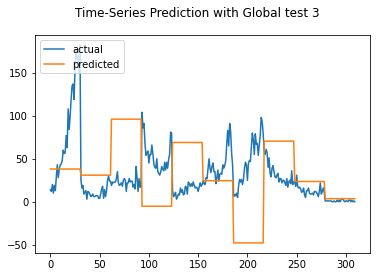

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.388
Test RMSE: 42.311
Test sMAPE: 131.032
Test R Squared: -0.804
{'mae': 35.38821294538437, 'rmse': 42.3106865908968, 'smape': 131.03172115646294, 'r2': -0.804409397107902}


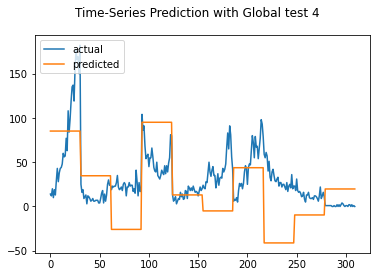

Test MAE: 39.508
Test RMSE: 53.888
Test sMAPE: 119.854
Test R Squared: -1.927
{'mae': 39.50755997934649, 'rmse': 53.887939342949416, 'smape': 119.85403689311978, 'r2': -1.9269687640164173}


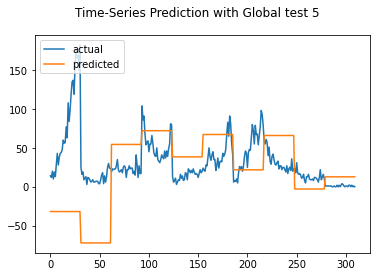

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.666
Test RMSE: 50.458
Test sMAPE: 96.619
Test R Squared: -1.566
{'mae': 43.665573040131605, 'rmse': 50.458495483109466, 'smape': 96.61863778687781, 'r2': -1.566276981936224}


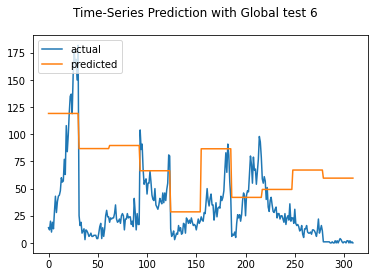

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 36.629
Test RMSE: 46.059
Test sMAPE: 132.143
Test R Squared: -1.138
{'mae': 36.62913717223752, 'rmse': 46.05876627839056, 'smape': 132.1427201701568, 'r2': -1.1382551967282373}


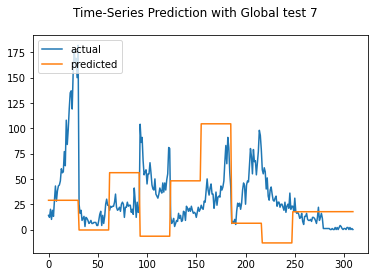

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 62.251
Test RMSE: 81.531
Test sMAPE: 129.551
Test R Squared: -5.700
{'mae': 62.251447957561865, 'rmse': 81.53140912104804, 'smape': 129.55100557132297, 'r2': -5.700154715216279}


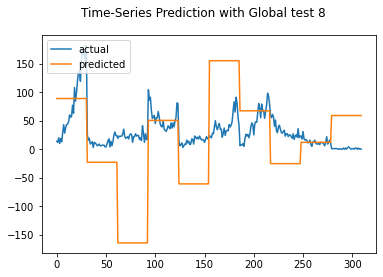

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 35.215
Test RMSE: 41.261
Test sMAPE: 110.267
Test R Squared: -0.716
{'mae': 35.21516514747373, 'rmse': 41.26106463704151, 'smape': 110.26677728911048, 'r2': -0.7159941137505264}


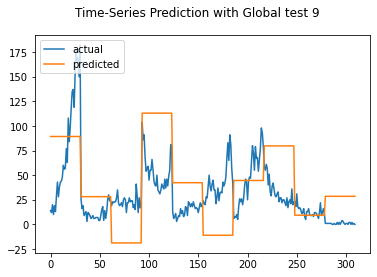

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 63.416
Test RMSE: 77.031
Test sMAPE: 141.990
Test R Squared: -4.981
{'mae': 63.41576843646265, 'rmse': 77.0307847929505, 'smape': 141.98976941515133, 'r2': -4.980859213859157}


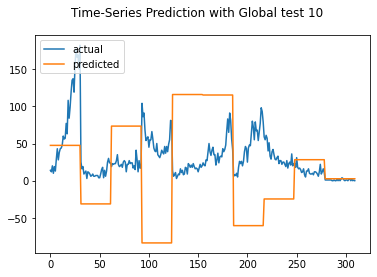

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 56.117
Test RMSE: 75.487
Test sMAPE: 136.672
Test R Squared: -4.744
{'mae': 56.11704005791295, 'rmse': 75.48697695612337, 'smape': 136.67223428062408, 'r2': -4.743531421766806}


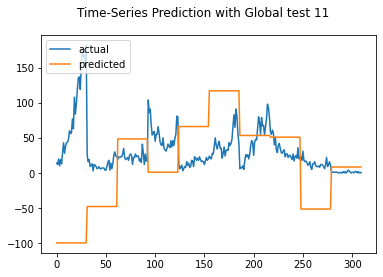

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 53.461
Test RMSE: 60.571
Test sMAPE: 120.589
Test R Squared: -2.698
{'mae': 53.46068580381332, 'rmse': 60.57095294796057, 'smape': 120.58890244905089, 'r2': -2.697973096213525}


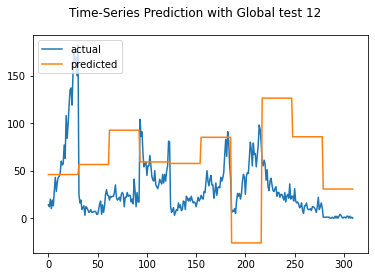

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 85.538
Test RMSE: 90.602
Test sMAPE: 126.022
Test R Squared: -7.274
{'mae': 85.53845022878339, 'rmse': 90.60168194965182, 'smape': 126.0218391982799, 'r2': -7.273846409628815}


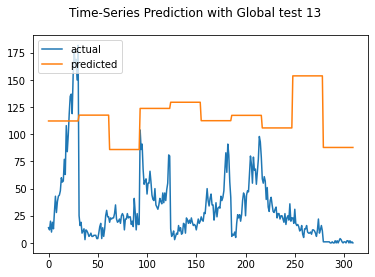

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 49.333
Test RMSE: 64.464
Test sMAPE: 115.475
Test R Squared: -3.189
{'mae': 49.33252634386862, 'rmse': 64.4639564493748, 'smape': 115.47468055027683, 'r2': -3.188599608295746}


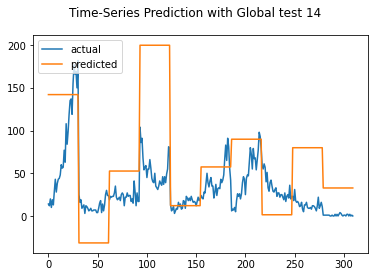

Test MAE: 81.800
Test RMSE: 90.676
Test sMAPE: 143.158
Test R Squared: -7.287
{'mae': 81.8000770445793, 'rmse': 90.67576985306995, 'smape': 143.15795804178995, 'r2': -7.287383521790234}


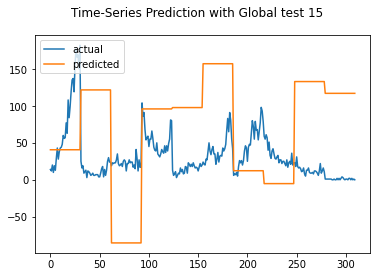

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 45.266
Test RMSE: 53.429
Test sMAPE: 127.416
Test R Squared: -1.877
{'mae': 45.26579877099683, 'rmse': 53.429420129745985, 'smape': 127.41585291081738, 'r2': -1.8773709596334585}


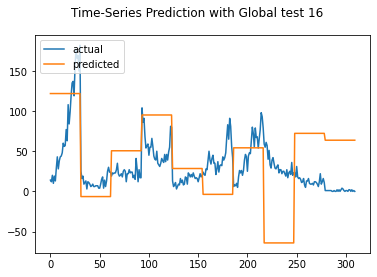

Test MAE: 99.251
Test RMSE: 130.264
Test sMAPE: 119.034
Test R Squared: -16.103
{'mae': 99.25066762739613, 'rmse': 130.2635605448479, 'smape': 119.0341417117785, 'r2': -16.103335855206517}


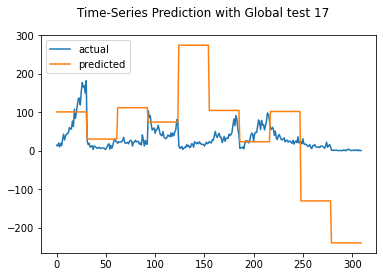

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 90.201
Test RMSE: 102.271
Test sMAPE: 122.171
Test R Squared: -9.542
{'mae': 90.20131577522524, 'rmse': 102.27104586753714, 'smape': 122.17141539595937, 'r2': -9.542420361496088}


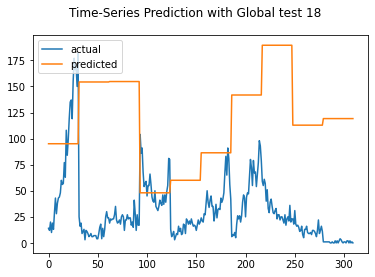

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.250
Test RMSE: 51.381
Test sMAPE: 109.776
Test R Squared: -1.661
{'mae': 42.25023897943958, 'rmse': 51.38143813467824, 'smape': 109.77585079042207, 'r2': -1.6610157555179623}


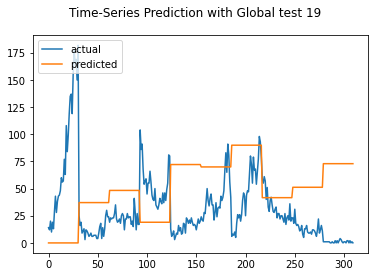

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 32.704
Test RMSE: 42.883
Test sMAPE: 102.413
Test R Squared: -0.854
{'mae': 32.70438919817248, 'rmse': 42.88326649490757, 'smape': 102.41255945388151, 'r2': -0.8535770872885311}


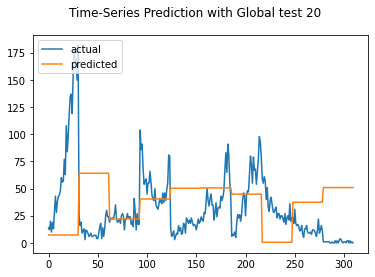

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 58.390
Test RMSE: 74.606
Test sMAPE: 112.600
Test R Squared: -4.610
{'mae': 58.38965424568423, 'rmse': 74.60614736965368, 'smape': 112.60044852871158, 'r2': -4.610275159866485}


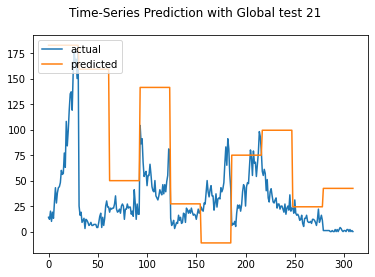

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 35.858
Test RMSE: 49.081
Test sMAPE: 118.787
Test R Squared: -1.428
{'mae': 35.858283826612656, 'rmse': 49.081228145734904, 'smape': 118.78730630454316, 'r2': -1.428095574078569}


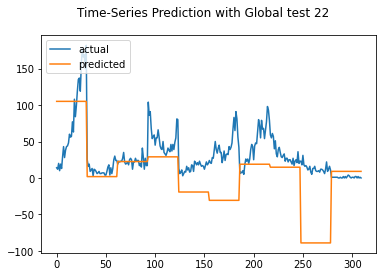

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 43.010
Test RMSE: 51.956
Test sMAPE: 111.363
Test R Squared: -1.721
{'mae': 43.010012032908776, 'rmse': 51.95557080173796, 'smape': 111.36273248593146, 'r2': -1.7208160165119804}


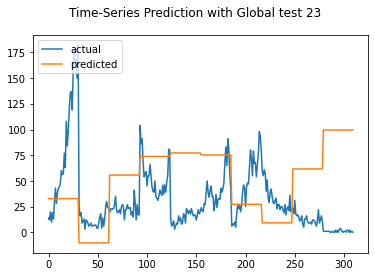

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 48.931
Test RMSE: 53.843
Test sMAPE: 105.534
Test R Squared: -1.922
{'mae': 48.9308479801301, 'rmse': 53.84251184338491, 'smape': 105.53414396790912, 'r2': -1.9220359783422696}


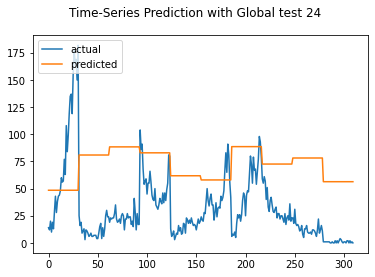

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.741
Test RMSE: 47.741
Test sMAPE: 113.233
Test R Squared: -1.297
{'mae': 35.74070172771331, 'rmse': 47.74131124987504, 'smape': 113.2327537655739, 'r2': -1.2973312519583957}


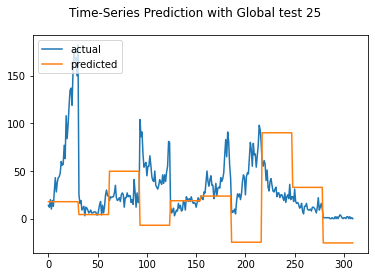

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 61.524
Test RMSE: 67.790
Test sMAPE: 111.381
Test R Squared: -3.632
{'mae': 61.524452960106636, 'rmse': 67.78999303307793, 'smape': 111.3811782127546, 'r2': -3.631974000841855}


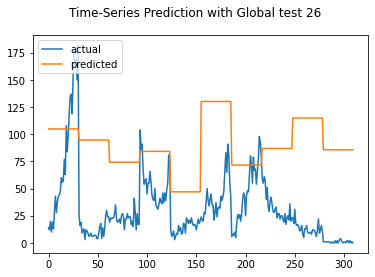

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 37.786
Test RMSE: 44.351
Test sMAPE: 94.298
Test R Squared: -0.983
{'mae': 37.78635343736219, 'rmse': 44.350529111274746, 'smape': 94.29795200806967, 'r2': -0.9825883293259681}


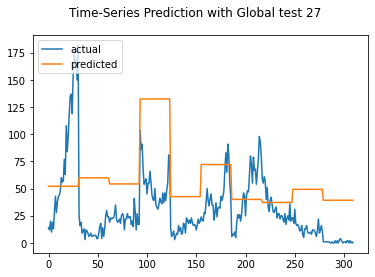

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 54.428
Test RMSE: 63.576
Test sMAPE: 147.569
Test R Squared: -3.074
{'mae': 54.42752807371078, 'rmse': 63.57605297223913, 'smape': 147.5690952566738, 'r2': -3.074009695569666}


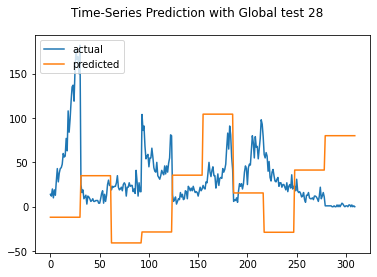

Test MAE: 67.290
Test RMSE: 85.638
Test sMAPE: 105.702
Test R Squared: -6.392
{'mae': 67.289504297318, 'rmse': 85.63817816356391, 'smape': 105.70213276596223, 'r2': -6.392133029327385}


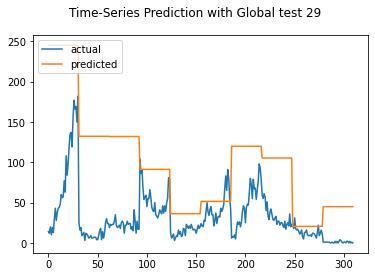

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 59.758
Test RMSE: 72.878
Test sMAPE: 183.538
Test R Squared: -4.353
{'mae': 59.75816832204019, 'rmse': 72.87802552968347, 'smape': 183.53821328071865, 'r2': -4.35338071665131}


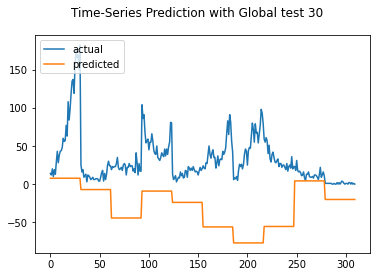

Test MAE: 45.587
Test RMSE: 53.524
Test sMAPE: 101.598
Test R Squared: -1.888
{'mae': 45.58658890262727, 'rmse': 53.52371516580359, 'smape': 101.59820868464737, 'r2': -1.8875361914171056}


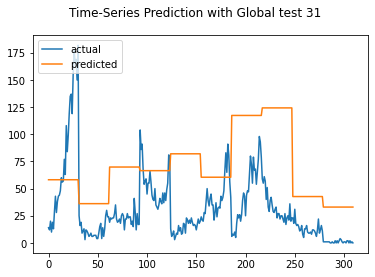

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 35.201
Test RMSE: 44.230
Test sMAPE: 117.719
Test R Squared: -0.972
{'mae': 35.20124453421562, 'rmse': 44.2304316880042, 'smape': 117.71863865691715, 'r2': -0.9718655094511164}


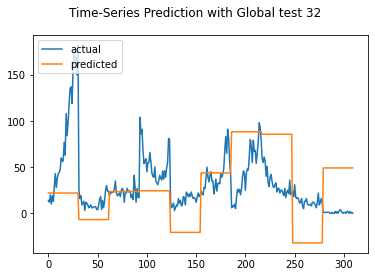

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 46.972
Test RMSE: 59.392
Test sMAPE: 137.135
Test R Squared: -2.555
{'mae': 46.97200800987982, 'rmse': 59.391600085672145, 'smape': 137.13494751520358, 'r2': -2.5553714957691422}


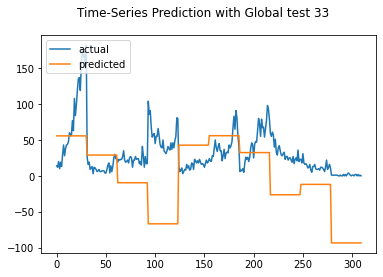

Test MAE: 46.405
Test RMSE: 61.832
Test sMAPE: 111.646
Test R Squared: -2.854
{'mae': 46.40544427441012, 'rmse': 61.83224225667341, 'smape': 111.64627451430495, 'r2': -2.8535848522733205}


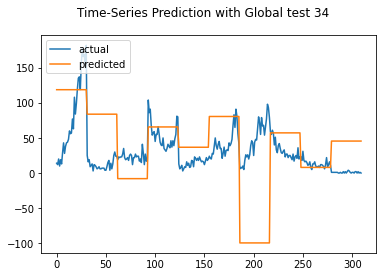

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.926
Test RMSE: 56.045
Test sMAPE: 143.198
Test R Squared: -2.166
{'mae': 43.92599469615567, 'rmse': 56.045052515023706, 'smape': 143.1981408303399, 'r2': -2.1659896835620396}


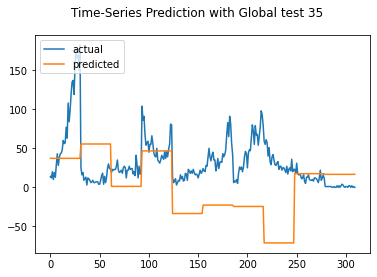

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 42.504
Test RMSE: 51.372
Test sMAPE: 109.121
Test R Squared: -1.660
{'mae': 42.50380531741727, 'rmse': 51.37211303381189, 'smape': 109.12103947043651, 'r2': -1.6600499597174654}


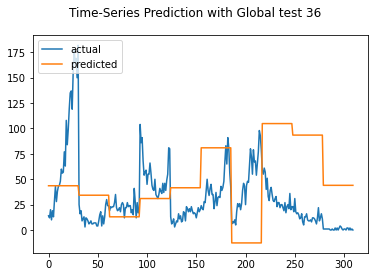

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 28.805
Test RMSE: 36.686
Test sMAPE: 84.641
Test R Squared: -0.357
{'mae': 28.80482714253088, 'rmse': 36.686198145565136, 'smape': 84.64148927411509, 'r2': -0.3565641922539964}


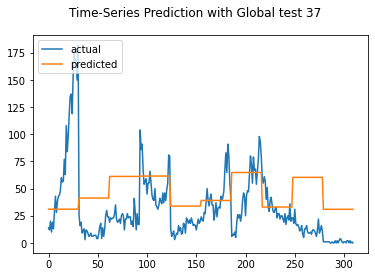

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 44.715
Test RMSE: 52.719
Test sMAPE: 95.476
Test R Squared: -1.801
{'mae': 44.714517876409715, 'rmse': 52.71883234428053, 'smape': 95.47644238448015, 'r2': -1.8013443679560952}


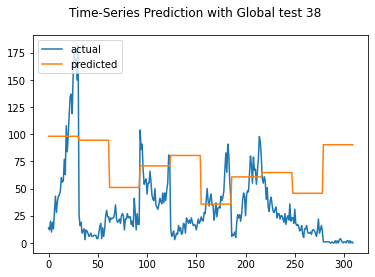

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 46.231
Test RMSE: 55.492
Test sMAPE: 128.753
Test R Squared: -2.104
{'mae': 46.230817122805504, 'rmse': 55.49205175458846, 'smape': 128.75299187795838, 'r2': -2.1038198037004765}


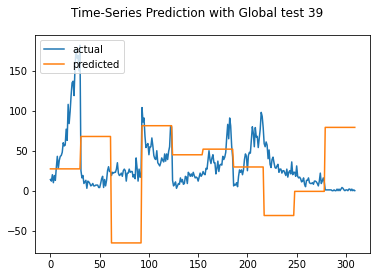

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 37.310
Test RMSE: 51.800
Test sMAPE: 133.140
Test R Squared: -1.705
{'mae': 37.309736901713954, 'rmse': 51.79984040327697, 'smape': 133.1397427016575, 'r2': -1.704529841957088}


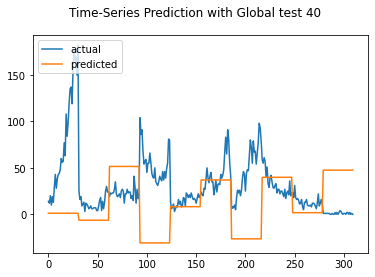

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 48.332
Test RMSE: 54.889
Test sMAPE: 101.534
Test R Squared: -2.037
{'mae': 48.33192382320281, 'rmse': 54.8891309637909, 'smape': 101.53422262111212, 'r2': -2.03674023867985}


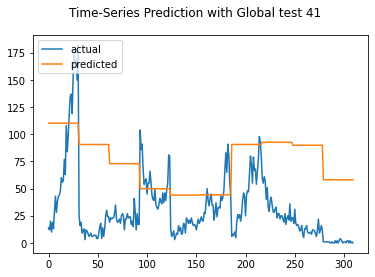

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 39.320
Test RMSE: 48.768
Test sMAPE: 100.092
Test R Squared: -1.397
{'mae': 39.31988127923781, 'rmse': 48.76845747891914, 'smape': 100.09197123900167, 'r2': -1.3972480447951572}


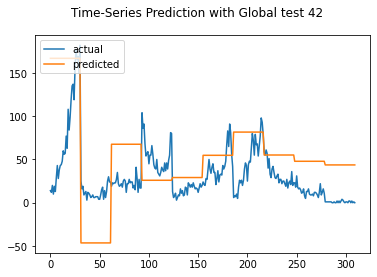

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 56.582
Test RMSE: 67.662
Test sMAPE: 137.057
Test R Squared: -3.614
{'mae': 56.58222344902254, 'rmse': 67.66163549360077, 'smape': 137.05704943677185, 'r2': -3.6144497061085508}


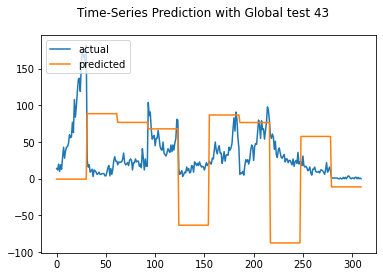

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 48.673
Test RMSE: 59.487
Test sMAPE: 145.658
Test R Squared: -2.567
{'mae': 48.673496303250715, 'rmse': 59.48653943423483, 'smape': 145.65787978810982, 'r2': -2.566747328079244}


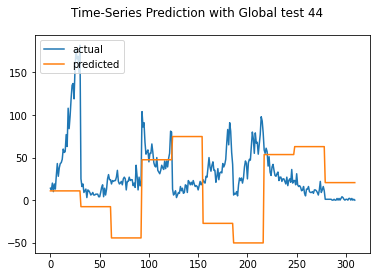

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 42.467
Test RMSE: 59.132
Test sMAPE: 96.797
Test R Squared: -2.524
{'mae': 42.46730517418154, 'rmse': 59.132170718457424, 'smape': 96.79684187601097, 'r2': -2.524378787320349}


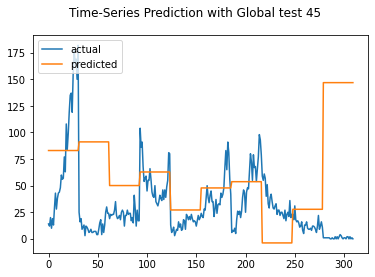

Test MAE: 35.357
Test RMSE: 44.699
Test sMAPE: 116.075
Test R Squared: -1.014
{'mae': 35.35701744325699, 'rmse': 44.69932316169398, 'smape': 116.07502171682297, 'r2': -1.0138950231660342}


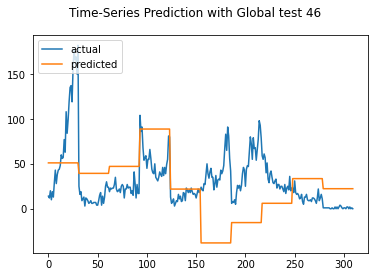

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 44.389
Test RMSE: 54.656
Test sMAPE: 94.294
Test R Squared: -2.011
{'mae': 44.389286736519104, 'rmse': 54.65620187516986, 'smape': 94.2939618653133, 'r2': -2.0110213297177753}


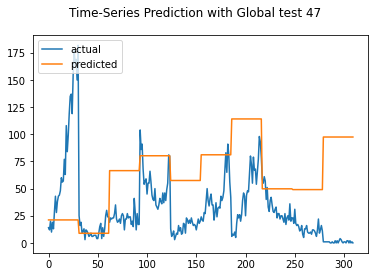

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 79.770
Test RMSE: 91.692
Test sMAPE: 135.917
Test R Squared: -7.474
{'mae': 79.77023919628512, 'rmse': 91.69168341618533, 'smape': 135.91679905120316, 'r2': -7.474124240638579}


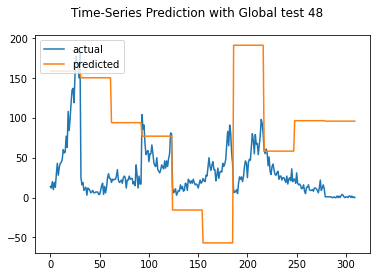

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 50.744
Test RMSE: 63.359
Test sMAPE: 100.363
Test R Squared: -3.046
{'mae': 50.744469944123296, 'rmse': 63.35941522867932, 'smape': 100.36300350471977, 'r2': -3.0462923237830246}


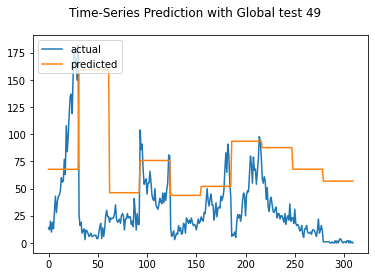

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 55.656
Test RMSE: 70.066
Test sMAPE: 116.487
Test R Squared: -3.948
{'mae': 55.65626064115955, 'rmse': 70.06612239383202, 'smape': 116.48702209231016, 'r2': -3.9482439378194183}


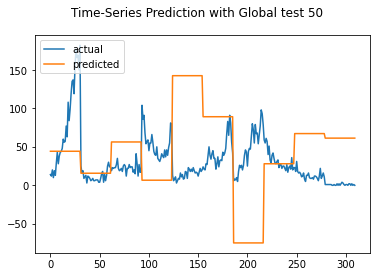

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 32.327
Test RMSE: 40.801
Test sMAPE: 92.027
Test R Squared: -0.678
{'mae': 32.327362398947436, 'rmse': 40.8014025199188, 'smape': 92.02678855960586, 'r2': -0.677973579324606}


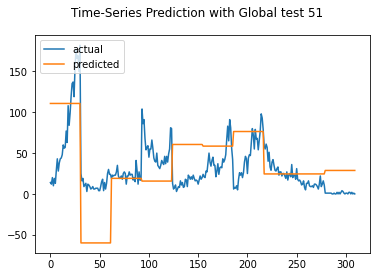

Test MAE: 37.552
Test RMSE: 51.182
Test sMAPE: 95.064
Test R Squared: -1.640
{'mae': 37.55188985024729, 'rmse': 51.18227077477707, 'smape': 95.06385197385832, 'r2': -1.6404262072459033}


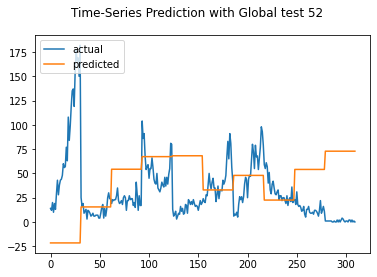

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 54.492
Test RMSE: 66.974
Test sMAPE: 99.906
Test R Squared: -3.521
{'mae': 54.49167365104921, 'rmse': 66.97393503248712, 'smape': 99.90583174567948, 'r2': -3.521125551376917}


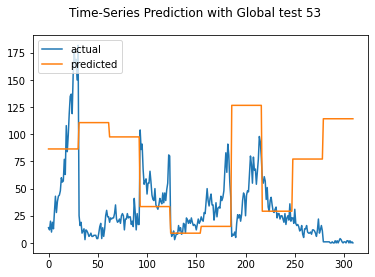

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 44.246
Test RMSE: 49.435
Test sMAPE: 133.572
Test R Squared: -1.463
{'mae': 44.24649775105138, 'rmse': 49.43542448039902, 'smape': 133.5717250062719, 'r2': -1.4632668921571037}


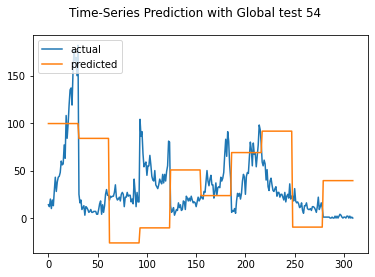

Test MAE: 31.688
Test RMSE: 43.564
Test sMAPE: 103.198
Test R Squared: -0.913
{'mae': 31.68818417979825, 'rmse': 43.563956998864036, 'smape': 103.19813530870987, 'r2': -0.9128881459089331}


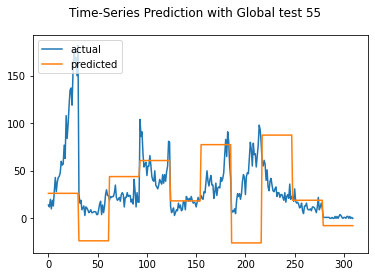

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 34.312
Test RMSE: 44.169
Test sMAPE: 123.675
Test R Squared: -0.966
{'mae': 34.31172577796444, 'rmse': 44.169175883701406, 'smape': 123.67451239729365, 'r2': -0.9664075221838242}


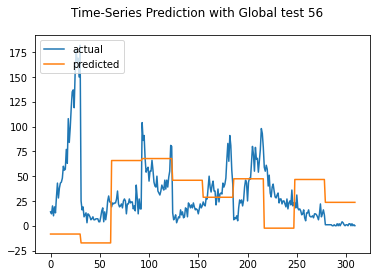

Test MAE: 31.409
Test RMSE: 43.004
Test sMAPE: 117.039
Test R Squared: -0.864
{'mae': 31.40936268452675, 'rmse': 43.003809666069785, 'smape': 117.0385240490461, 'r2': -0.8640123975324083}


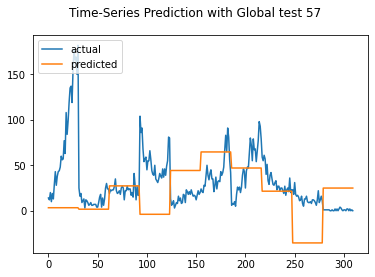

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.992
Test RMSE: 48.800
Test sMAPE: 104.582
Test R Squared: -1.400
{'mae': 41.99241331777265, 'rmse': 48.80001538826197, 'smape': 104.58155658113694, 'r2': -1.4003515513445572}


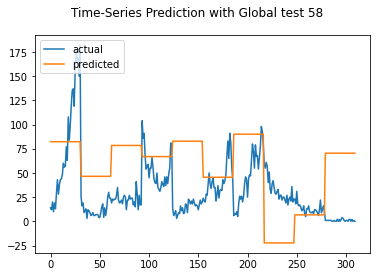

Test MAE: 37.972
Test RMSE: 49.584
Test sMAPE: 87.404
Test R Squared: -1.478
{'mae': 37.97180092719294, 'rmse': 49.58362120351109, 'smape': 87.40374689862425, 'r2': -1.478057712830926}


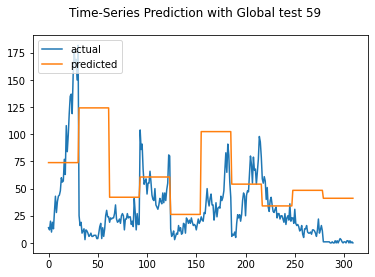

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 39.117
Test RMSE: 46.970
Test sMAPE: 103.702
Test R Squared: -1.224
{'mae': 39.117041778564456, 'rmse': 46.96981507420557, 'smape': 103.7024550015747, 'r2': -1.2236817671119713}


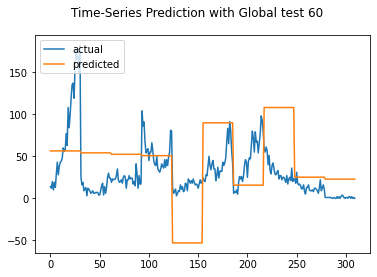

Test MAE: 52.403
Test RMSE: 61.408
Test sMAPE: 104.781
Test R Squared: -2.801
{'mae': 52.40331319378269, 'rmse': 61.4079810730338, 'smape': 104.78107389073337, 'r2': -2.8008836272458035}


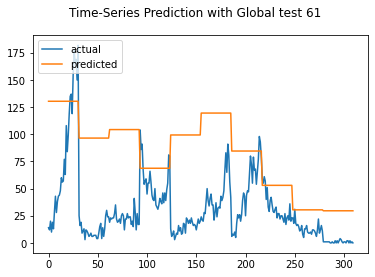

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 29.438
Test RMSE: 40.280
Test sMAPE: 120.521
Test R Squared: -0.635
{'mae': 29.438381264286658, 'rmse': 40.28029081549386, 'smape': 120.5208109795986, 'r2': -0.6353854492057252}


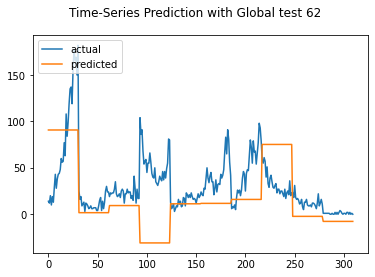

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 34.679
Test RMSE: 41.731
Test sMAPE: 107.142
Test R Squared: -0.755
{'mae': 34.67855598234361, 'rmse': 41.73060565264053, 'smape': 107.14166189327314, 'r2': -0.7552715357429438}


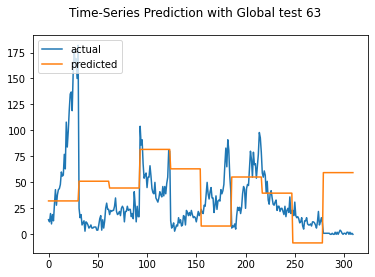

Test MAE: 72.324
Test RMSE: 81.216
Test sMAPE: 114.987
Test R Squared: -5.648
{'mae': 72.32445958045221, 'rmse': 81.21605812719947, 'smape': 114.9870520693154, 'r2': -5.648424608167332}


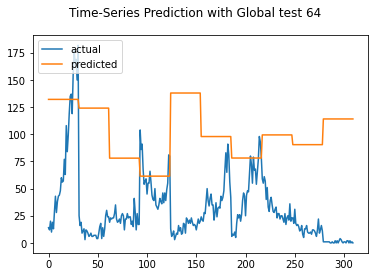

Test MAE: 50.661
Test RMSE: 57.418
Test sMAPE: 123.054
Test R Squared: -2.323
{'mae': 50.661309940584246, 'rmse': 57.41825765379447, 'smape': 123.05442258988118, 'r2': -2.3230352947017674}


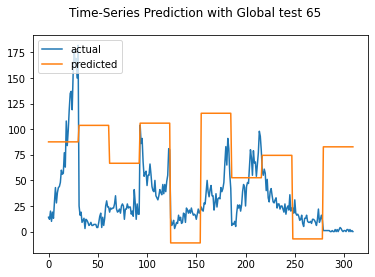

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 46.564
Test RMSE: 56.572
Test sMAPE: 166.845
Test R Squared: -2.226
{'mae': 46.564168016372186, 'rmse': 56.571557810041455, 'smape': 166.8451613080255, 'r2': -2.2257537484987715}


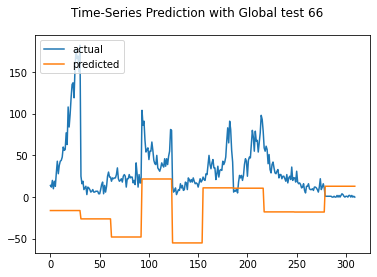

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 45.784
Test RMSE: 54.123
Test sMAPE: 135.223
Test R Squared: -1.953
{'mae': 45.78356957724017, 'rmse': 54.12299555385183, 'smape': 135.2231202290745, 'r2': -1.952559005886862}


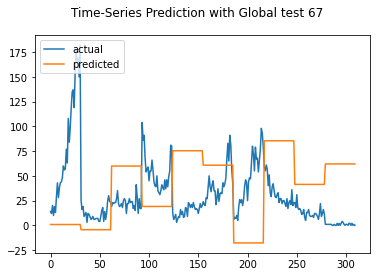

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 34.259
Test RMSE: 42.033
Test sMAPE: 91.628
Test R Squared: -0.781
{'mae': 34.25940562217466, 'rmse': 42.0332297570329, 'smape': 91.6278602941058, 'r2': -0.7808217770661994}


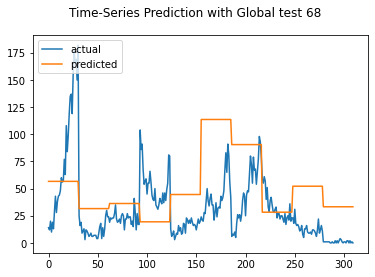

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 59.601
Test RMSE: 74.518
Test sMAPE: 126.973
Test R Squared: -4.597
{'mae': 59.60093441932432, 'rmse': 74.51773451273735, 'smape': 126.97282562462435, 'r2': -4.596985998982856}


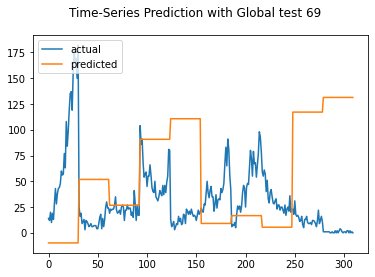

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 37.854
Test RMSE: 45.265
Test sMAPE: 115.921
Test R Squared: -1.065
{'mae': 37.85382351490759, 'rmse': 45.26467604723383, 'smape': 115.92133164666541, 'r2': -1.065160299265683}


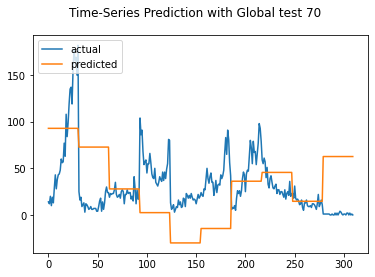

Test MAE: 52.647
Test RMSE: 67.233
Test sMAPE: 96.859
Test R Squared: -3.556
{'mae': 52.647009468078615, 'rmse': 67.23259572924034, 'smape': 96.85932414972844, 'r2': -3.5561151553981656}


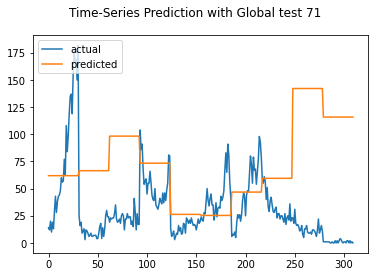

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 40.059
Test RMSE: 53.222
Test sMAPE: 103.521
Test R Squared: -1.855
{'mae': 40.05921772064702, 'rmse': 53.222086740746256, 'smape': 103.52073179103888, 'r2': -1.8550829556344062}


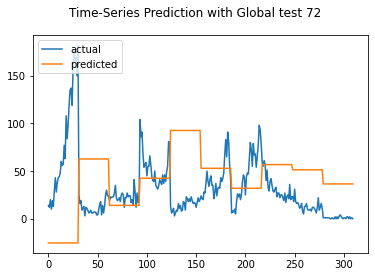

Test MAE: 38.851
Test RMSE: 51.665
Test sMAPE: 103.047
Test R Squared: -1.691
{'mae': 38.850935751391994, 'rmse': 51.6654939237576, 'smape': 103.04722090422437, 'r2': -1.6905192627282588}


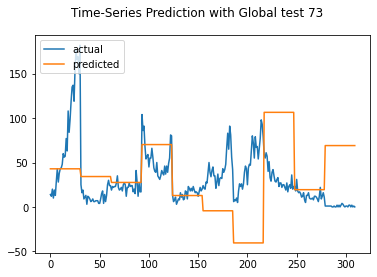

Test MAE: 43.019
Test RMSE: 54.900
Test sMAPE: 120.418
Test R Squared: -2.038
{'mae': 43.0188341940603, 'rmse': 54.89967511003193, 'smape': 120.41755455794632, 'r2': -2.0379070601652365}


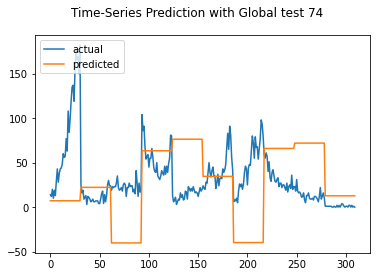

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 34.357
Test RMSE: 48.313
Test sMAPE: 124.413
Test R Squared: -1.353
{'mae': 34.35708809744927, 'rmse': 48.31288207535115, 'smape': 124.41326553426639, 'r2': -1.3526689789839157}


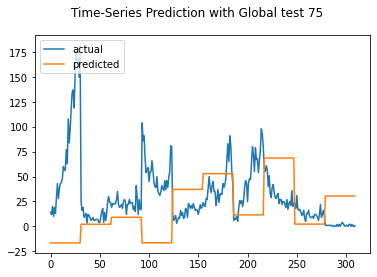

Test MAE: 65.341
Test RMSE: 87.534
Test sMAPE: 121.679
Test R Squared: -6.723
{'mae': 65.34133598804473, 'rmse': 87.53447148190605, 'smape': 121.67879695411337, 'r2': -6.723126747301539}


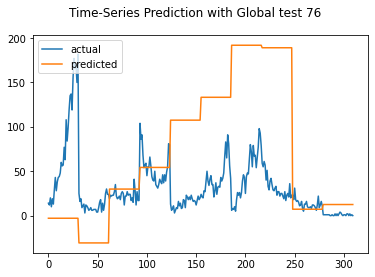

Test MAE: 60.844
Test RMSE: 71.574
Test sMAPE: 124.047
Test R Squared: -4.163
{'mae': 60.84414024968301, 'rmse': 71.57372884871933, 'smape': 124.04746238022504, 'r2': -4.163476702710741}


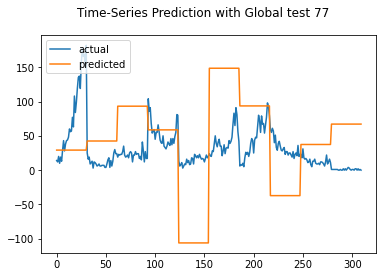

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 54.142
Test RMSE: 70.412
Test sMAPE: 128.856
Test R Squared: -3.997
{'mae': 54.141923041497506, 'rmse': 70.41241503716813, 'smape': 128.85648124608738, 'r2': -3.9972769052283708}


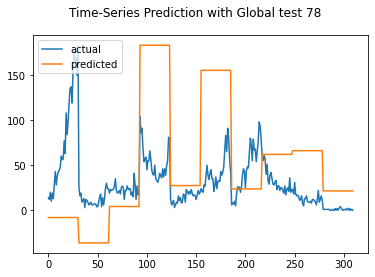

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 33.474
Test RMSE: 48.946
Test sMAPE: 126.256
Test R Squared: -1.415
{'mae': 33.47413497201858, 'rmse': 48.94571468347146, 'smape': 126.255569754143, 'r2': -1.4147061211043006}


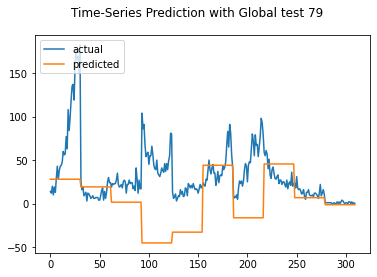

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.274
Test RMSE: 46.217
Test sMAPE: 95.318
Test R Squared: -1.153
{'mae': 40.27371178903887, 'rmse': 46.21732603545033, 'smape': 95.31789259528938, 'r2': -1.1530026524552328}


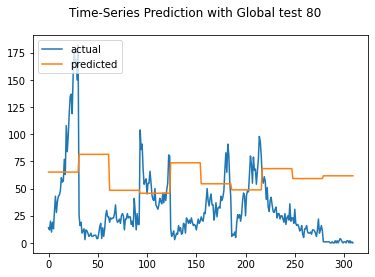

Test MAE: 70.477
Test RMSE: 84.789
Test sMAPE: 118.792
Test R Squared: -6.246
{'mae': 70.47683959007263, 'rmse': 84.78880019521335, 'smape': 118.79245232392195, 'r2': -6.246226653408913}


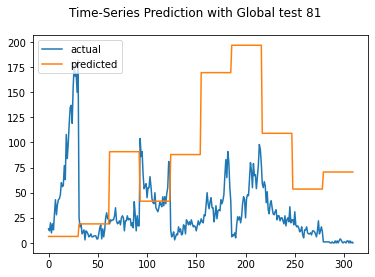

Test MAE: 36.236
Test RMSE: 43.121
Test sMAPE: 122.499
Test R Squared: -0.874
{'mae': 36.23575602039214, 'rmse': 43.1206290576244, 'smape': 122.49879706081383, 'r2': -0.8741532923692965}


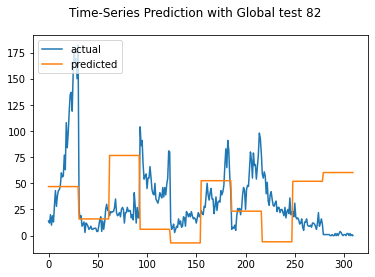

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 92.191
Test RMSE: 106.004
Test sMAPE: 122.987
Test R Squared: -10.326
{'mae': 92.19076918325116, 'rmse': 106.00366342942884, 'smape': 122.98651851283523, 'r2': -10.326003291530897}


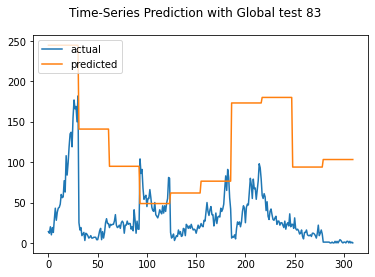

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 40.485
Test RMSE: 48.423
Test sMAPE: 120.423
Test R Squared: -1.363
{'mae': 40.48499136278706, 'rmse': 48.422639862400715, 'smape': 120.42255077061151, 'r2': -1.363370764826108}


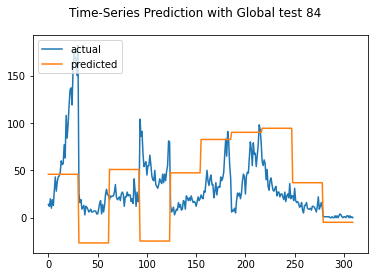

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 37.445
Test RMSE: 45.662
Test sMAPE: 148.890
Test R Squared: -1.102
{'mae': 37.44456096541497, 'rmse': 45.66188471649708, 'smape': 148.88992741128177, 'r2': -1.1015639062957017}


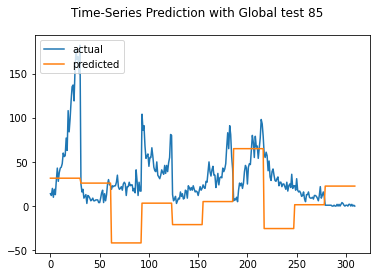

Test MAE: 72.659
Test RMSE: 83.551
Test sMAPE: 113.351
Test R Squared: -6.036
{'mae': 72.65913848876953, 'rmse': 83.55113959184634, 'smape': 113.35062462032717, 'r2': -6.036224538305723}


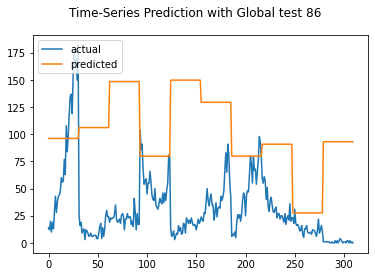

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 41.712
Test RMSE: 46.125
Test sMAPE: 96.583
Test R Squared: -1.144
{'mae': 41.712390948880106, 'rmse': 46.124773092604215, 'smape': 96.58295470114827, 'r2': -1.1443882549217275}


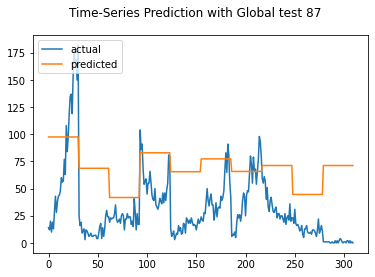

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.818
Test RMSE: 47.781
Test sMAPE: 101.637
Test R Squared: -1.301
{'mae': 38.81835354835757, 'rmse': 47.78069397240958, 'smape': 101.63694157329131, 'r2': -1.3011230404217842}


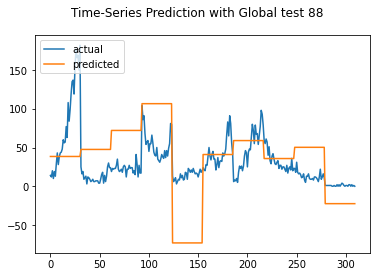

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 49.401
Test RMSE: 59.559
Test sMAPE: 119.301
Test R Squared: -2.575
{'mae': 49.40080258461737, 'rmse': 59.55883068017972, 'smape': 119.300707850028, 'r2': -2.575421602430971}


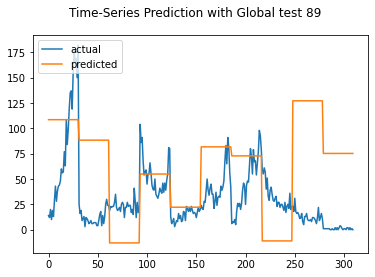

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 36.820
Test RMSE: 49.124
Test sMAPE: 108.258
Test R Squared: -1.432
{'mae': 36.82016176408337, 'rmse': 49.124384410664334, 'smape': 108.25771917795412, 'r2': -1.4323674152183559}


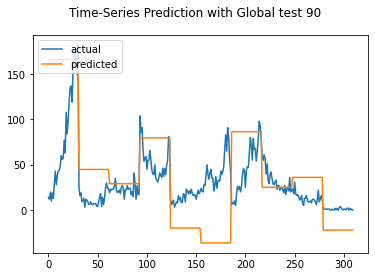

Test MAE: 68.456
Test RMSE: 78.702
Test sMAPE: 124.982
Test R Squared: -5.243
{'mae': 68.45641641309184, 'rmse': 78.70194430023655, 'smape': 124.98154032543327, 'r2': -5.243180016698536}


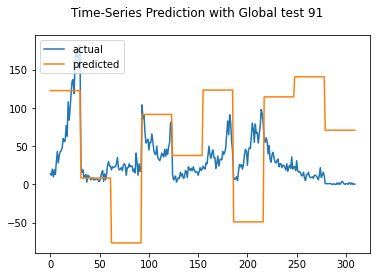

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 51.495
Test RMSE: 65.091
Test sMAPE: 130.470
Test R Squared: -3.271
{'mae': 51.49458726375334, 'rmse': 65.09148885355691, 'smape': 130.47023547013626, 'r2': -3.2705454201964166}


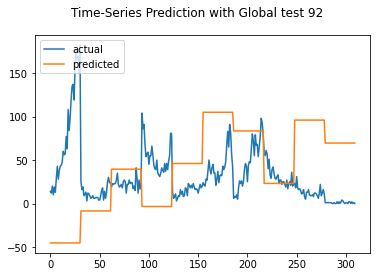

Test MAE: 92.283
Test RMSE: 112.450
Test sMAPE: 117.619
Test R Squared: -11.745
{'mae': 92.28252965865596, 'rmse': 112.45021954134083, 'smape': 117.619424744083, 'r2': -11.745461041386404}


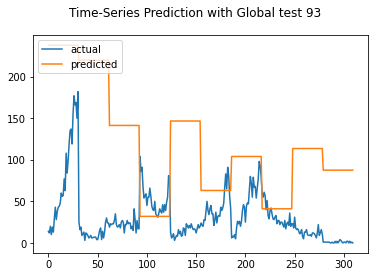

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 39.584
Test RMSE: 46.916
Test sMAPE: 97.691
Test R Squared: -1.219
{'mae': 39.584031504969445, 'rmse': 46.91578896843407, 'smape': 97.69144607009785, 'r2': -1.2185692166951179}


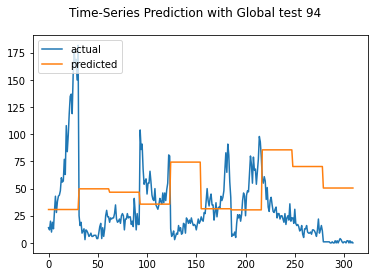

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.448
Test RMSE: 59.130
Test sMAPE: 100.778
Test R Squared: -2.524
{'mae': 40.44831858335003, 'rmse': 59.12975349977129, 'smape': 100.77845208979441, 'r2': -2.524090652451177}


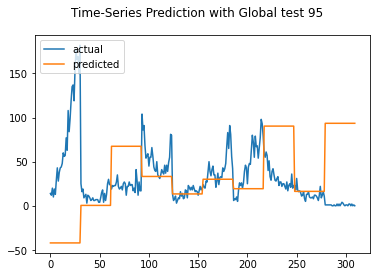

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 64.020
Test RMSE: 101.266
Test sMAPE: 108.437
Test R Squared: -9.336
{'mae': 64.02009654198923, 'rmse': 101.26579796994217, 'smape': 108.43726219257094, 'r2': -9.336190692949367}


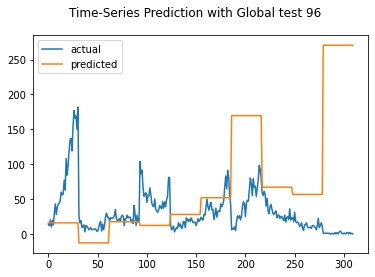

Test MAE: 50.425
Test RMSE: 55.886
Test sMAPE: 127.863
Test R Squared: -2.148
{'mae': 50.42483169840228, 'rmse': 55.88591698722287, 'smape': 127.86256454715866, 'r2': -2.1480360503326277}


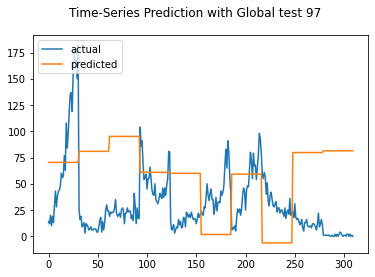

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 26.296
Test RMSE: 32.106
Test sMAPE: 109.651
Test R Squared: -0.039
{'mae': 26.295940219971445, 'rmse': 32.106438322262676, 'smape': 109.65119888806798, 'r2': -0.039008727090864115}


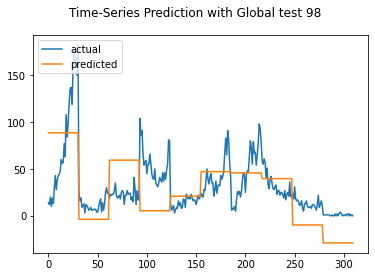

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 35.139
Test RMSE: 45.701
Test sMAPE: 144.308
Test R Squared: -1.105
{'mae': 35.13947824662731, 'rmse': 45.70075451349543, 'smape': 144.30762840176214, 'r2': -1.1051433525324494}


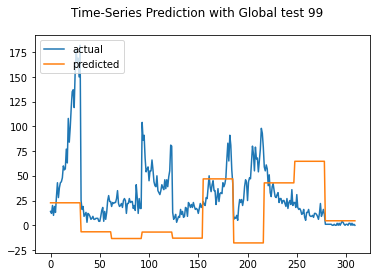

rmse : average=59.593, std=17.771
mae : average=48.341, std=15.181
smape : average=116.840, std=17.111
r2 : average=-2.898, std=2.640


([59.593384039130754, 17.77114745690276],
 [48.34127239259981, 15.18076933054749],
 [116.84005190523371, 17.11077061047531],
 [-2.8978928327008795, 2.6400221461504407])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')